In [1]:
import pandas as pd
import polars as pl
from data import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from missforest import MissForest
import pickle
import joblib
from lightgbm import LGBMClassifier, LGBMRegressor
import pyarrow
import sklearn
from sklearn.svm import SVR, LinearSVR
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import json
import numpy as np
import shap
from scipy import stats
from typing import Any, cast, Final
from utils import *
import wrds
from xgboost import XGBRegressor

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Fetching missing data

## 1.1. Reading all the predictor values

In [2]:
full_data = pl.read_csv(get_data_file_path("signed_predictors_all_wide.csv"), schema_overrides=SIGNED_PREDICTORS_ENTRY_SCHEMA)
full_data = full_data.sort(by=["yyyymm", "permno"], maintain_order=True)
full_data.insert_column(2, full_data["yyyymm"].str.to_date("%Y%m").alias("date"))
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.691348,-11.088278
10014,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
10022,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.025352,-9.323669
10030,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-5.010635,-10.060491
10049,"""192512""",1925-12-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,-4.304065,-9.825526
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
85272,"""202410""",2024-10-01,null,null,null,-0.082707,null,null,null,null,null,null,null,null,-0.574621,null,null,null,null,null,null,null,null,-1.298188,null,null,null,null,null,null,-0.792602,-1.482673,null,-0.110388,null,null,…,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,-0.216307,null,null,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
88841,"""202410""",2024-10-01,null,null,0.046021,0.070207,null,null,null,null,null,null,null,null,0.085084,null,null,null,null,null,null,null,null,-1.26169,null,null,null,null,null,null,0.053662,-1.112958,null,0.0,null,null,…,null,null,1.1701046,-0.039176,null,null,null,null,null,null,0.135177,null,null,null,0.048669,null,null,null,null,null,0.04735,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
89986,"""202410""",2024-10-01,null,null,0.567842,0.43184

In [3]:
full_data = full_data.filter((pl.col("date") >= date(1972, 11, 1)) & (pl.col("date") <= date(2023, 12, 31)))
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155
10014,"""197211""",1972-11-01,2.3547554,null,0.094414,0.173883,1.0,null,null,null,null,null,null,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.13817,0.023141,-1.854014,null,0.232317,0.177941,null,null,5.5586514,0.402247,-1.067354,null,0.116868,-0.253702,null,…,0.0,null,2.1719143,-0.01237,null,null,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,null,0.109633,null,null,null,-0.208027,-0.958571,0.222222,null,null,-0.234734,null,0.008438,null,null,null,-0.022901,0.641664,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267
10023,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,0.0,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301
10058,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93426,"""202312""",2023-12-01,null,null,-0.037102,0.005406,null,null,null,null,null,null,null,null,-0.032157,null,null,null,null,null,null,null,null,-1.534121,null,null,null,null,null,null,-0.036009,-1.106272,null,-0.017543,null,null,…,null,1.0,0.830135,-0.052671,null,null,null,null,null,null,0.006658,null,null,null,-0.042883,null,null,null,null,null,-0.037736,nu

## 1.2. Fetching the missing monthly returns from WRDS

In [3]:
MIN_DATE = full_data["date"].min()
MAX_DATE = full_data["date"].max()
MIN_PERMNO = full_data["permno"].min()
MAX_PERMNO = full_data["permno"].max()

db = wrds.Connection(wrds_username=get_env("WRDS_USERNAME"))

# Query to get the stock returns
query = f"""
SELECT permno, mthcaldt, mthret
FROM crsp.msf_v2
WHERE permno BETWEEN {MIN_PERMNO} AND {MAX_PERMNO}
AND mthcaldt BETWEEN '{MIN_DATE.strftime("%Y-%m-%d")}' AND '{MAX_DATE.strftime("%Y-%m-%d")}'
"""

# Execute the query
all_returns_data = pl.DataFrame(db.raw_sql(query))

# Close the connection
db.close()

Loading library list...
Done


## 1.3. Analyzing the return values

In [14]:
all_returns_data.insert_column(1, pl.Series("yyyymm", all_returns_data.get_column("mthcaldt").apply(lambda x: x.strftime("%Y%m"))))
all_returns_data = all_returns_data.rename({"mthcaldt": "date", "mthret": "ret"})
all_returns_data

permno,yyyymm,date,ret
i64,str,date,f64
10000,"""198601""",1986-01-31,0.707317
10000,"""198602""",1986-02-28,-0.257143
10000,"""198603""",1986-03-31,0.365385
10000,"""198604""",1986-04-30,-0.098592
10000,"""198605""",1986-05-30,-0.222656
…,…,…,…
93436,"""202308""",2023-08-31,-0.034962
93436,"""202309""",2023-09-29,-0.030456
93436,"""202310""",2023-10-31,-0.197346


### Displaying summary statistics

In [15]:
all_returns_data.describe()

statistic,permno,yyyymm,date,ret
str,f64,str,str,f64
"""count""",5.001721e6,"""5001721""","""5001721""",4.91856e6
"""null_count""",0.0,"""0""","""0""",83161.0
"""mean""",52557.890819,null,"""1994-02-19""",0.009909
"""std""",29509.729138,null,null,0.172307
"""min""",10000.0,"""192512""","""1925-12-31""",-1.0
"""25%""",20969.0,null,"""1982-01-29""",-0.057826
"""50%""",54894.0,null,"""1996-10-31""",0.0
"""75%""",80717.0,null,"""2010-05-28""",0.062112
"""max""",93436.0,"""202312""","""2023-12-29""",24.0


### Retrieving the percentage of nulls in each column

In [16]:
all_returns_data.null_count() / len(all_returns_data)

permno,yyyymm,date,ret
f64,f64,f64,f64
0.0,0.0,0.0,0.016626


### Saving the return values in the `data/` directory.

In [24]:
all_returns_data.write_csv(get_data_file_path("1_3_all_returns_values.csv"))

## 1.4. Joining the returns with the original data

In [4]:
all_returns_data = pl.read_csv(get_data_file_path("1_3_all_returns_values.csv"), schema_overrides={"yyyymm": pl.String, "date": pl.Date})
all_returns_data

permno,yyyymm,date,ret
i64,str,date,f64
10000,"""198601""",1986-01-31,0.707317
10000,"""198602""",1986-02-28,-0.257143
10000,"""198603""",1986-03-31,0.365385
10000,"""198604""",1986-04-30,-0.098592
10000,"""198605""",1986-05-30,-0.222656
…,…,…,…
93436,"""202308""",2023-08-31,-0.034962
93436,"""202309""",2023-09-29,-0.030456
93436,"""202310""",2023-10-31,-0.197346


In [5]:
full_data = full_data.join(all_returns_data, on=("yyyymm", "permno"))
full_data = full_data.sort(by=["yyyymm", "permno"], maintain_order=True).drop("date_right")
full_data

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,null,-0.036283,0.032336,null,null,null,0.005684,null,null,null,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.238189,0.000732,-1.962242,-250.17551,0.119151,0.142407,null,null,16.849766,-0.052076,-1.016543,null,0.012778,0.055488,null,…,0.0,0.563577,-0.008061,0.1265153,null,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,null,-0.044096,null,null,null,0.1166129,-0.828235,0.105059,null,null,-0.345847,null,null,null,null,null,null,0.756519,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289
10014,"""197211""",1972-11-01,2.3547554,null,0.094414,0.173883,1.0,null,null,null,null,null,null,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.13817,0.023141,-1.854014,null,0.232317,0.177941,null,null,5.5586514,0.402247,-1.067354,null,0.116868,-0.253702,null,…,null,2.1719143,-0.01237,null,null,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,null,0.109633,null,null,null,-0.208027,-0.958571,0.222222,null,null,-0.234734,null,0.008438,null,null,null,-0.022901,0.641664,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267,0.0
10057,"""197211""",1972-11-01,1.3478317,null,-0.05239,0.050687,null,null,null,null,null,null,null,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.260488,0.008738,-1.394205,null,0.134335,0.038479,null,0.022156,6.0799537,-0.343798,-0.945671,null,0.024256,0.493721,null,…,null,2.4113321,0.030292,0.118428,null,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,null,0.024986,null,null,null,0.530716,-0.456507,0.135553,null,null,-0.044186,null,null,null,null,null,-0.004108,0.783954,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034
10065,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.530412,1.0972391,-0.03315,null,0.008889,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,-0.006325,-0.015328,-0.005452,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.3752e-7,4.2518e-7,3.1820e-7,-6.6667,-2.639057,-12.043648,0.066667
10102,"""197211""",1972-11-01,2.8037627,null,-0.006352,0.034338,null,null,null,null,null,null,null,0.021162,-0.033163,0.091918,1.4261148,9.0310478,0.800822,2.0441911,-0.106429,0.245022,0.007959,-1.705458,null,0.116609,0.220319,null,null,18.190111,-0.007461,-1.04883,null,-0.031813,0.408558,null,…,0.0,0.154531,-0.009669,0.137479,null,-0.001911,-0.03019,-0.173491,0.000127,0.017115,null,-0.071019,null,-0.001587,null,null,null,0.417722,-0.689695,0.036699,null,null,-0.213956,null,null,null,null,null,null,0.751193,1.3238e-7,5.9608e-8,1.1357e-7,-6.2774,-2.890372,-12.245505,0.062938
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93426,"""202312""",2023-12-01,null,null,-0.037102,0.005406,null,null,null,null,null,null,null,nul

### Saving the return values in the `data/` directory.

In [6]:
full_data.write_csv(get_data_file_path("1_4_complete_dataset.csv"))

<hr>

# 2. Analysis and cleaning of full dataset

## 2.1 Analysis

### Retrieving the previously computed data and analyzing it

In [2]:
full_data = pl.read_csv(get_data_file_path("1_4_complete_dataset.csv"), schema_overrides=ALL_DATA_WITH_DATES_ENTRY_SCHEMA)

### Summary statistics

In [7]:
full_data.describe()

statistic,permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.336216e6,"""4336216""","""4336216""",2.701919e6,1.15785e6,2.306086e6,2.771079e6,207586.0,108731.0,30170.0,1.000076e6,323539.0,1.831642e6,1.15785e6,2.780251e6,2.7843e6,2.438787e6,2.693432e6,2.684341e6,3.512052e6,3.100346e6,3.095873e6,1.818359e6,3.598072e6,3.06388e6,427502.0,2.082973e6,2.701919e6,665346.0,2.003163e6,2.680822e6,2.104545e6,2.67381e6,598245.0,2.784342e6,2.390269e6,…,1.364324e6,2.719508e6,2.659375e6,1.521609e6,443513.0,2.276411e6,3.527007e6,3.161132e6,2.940102e6,2.718347e6,3.141841e6,2.462629e6,797950.0,2.782229e6,797950.0,797950.0,840921.0,2.173951e6,1.989513e6,3.024389e6,1.56695e6,1.567902e6,1.343777e6,707340.0,2.387078e6,561785.0,169945.0,458208.0,1.735953e6,1.248277e6,3.65754e6,3.800056e6,3.435317e6,4.336192e6,4.231072e6,4.231072e6,4.257839e6
"""null_count""",0.0,"""0""","""0""",1.634297e6,3.178366e6,2.03013e6,1.565137e6,4.12863e6,4.227485e6,4.306046e6,3.33614e6,4.012677e6,2.504574e6,3.178366e6,1.555965e6,1.551916e6,1.897429e6,1.642784e6,1.651875e6,824164.0,1.23587e6,1.240343e6,2.517857e6,738144.0,1.272336e6,3.908714e6,2.253243e6,1.634297e6,3.67087e6,2.333053e6,1.655394e6,2.231671e6,1.662406e6,3.737971e6,1.551874e6,1.945947e6,…,2.971892e6,1.616708e6,1.676841e6,2.814607e6,3.892703e6,2.059805e6,809209.0,1.175084e6,1.396114e6,1.617869e6,1.194375e6,1.873587e6,3.538266e6,1.553987e6,3.538266e6,3.538266e6,3.495295e6,2.162265e6,2.346703e6,1.311827e6,2.769266e6,2.768314e6,2.992439e6,3.628876e6,1.949138e6,3.774431e6,4.166271e6,3.878008e6,2.600263e6,3.087939e6,678676.0,536160.0,900899.0,24.0,105144.0,105144.0,78377.0
"""mean""",57080.739158,null,"""1999-12-31""",3.848548,-167.987622,-0.002061,0.030441,0.483987,14.8865,9.263089,0.074976,18.541335,1.006447,0.761476,0.00266,-0.188596,-0.743404,3.01391,0.013737,0.98804,0.918899,0.000125,0.692003,0.017482,-4.170478,-2657.91128,0.092546,-0.000261,-0.009441,0.163805,14.093706,-0.125069,-1.322929,0.4765,-0.010104,-62.293334,…,0.286724,1.145398,-0.007906,0.189363,0.352181,-0.939135,-0.194164,-5.517591,-0.006062,-0.062583,-0.00046,0.005568,0.000138,-0.103481,0.000396,-0.000534,-16.736662,-3.572018,8.4534e10,-0.041708,1.725571,1.59892,-4.3991e-11,0.010877,-0.007347,0.005598,0.188255,-0.067404,-0.193662,0.687651,1.314702,1.39393,1.244107,-0.922302,-2.417701,inf,0.009535
"""std""",28865.438233,null,null,28.203881,49157.458375,0.149632,0.126656,0.499745,2.724359,12.642133,0.362023,22.924938,4.870561,1.531836,0.10091,2.898215,1.054689,54.417337,346.132937,0.774412,0.613358,0.458023,0.527905,0.032428,208.642116,73351.332682,0.218522,2.468889,0.063112,0.210359,4033.676255,299.183141,13.968044,0.499448,0.065337,1.0644e13,…,0.452232,19.838503,0.814822,0.158552,0.477651,56.471506,1.780256,38.873511,0.020741,0.488792,0.017131,1.525522,0.193816,2.031764,0.182771,0.185065,12.008629,355.983617,4.4808e13,0.274167,5.96922,5.223386,0.2498,0.083283,0.2915,1.49462,0.390917,0.084423,2.696227,0.18742,3.141981,3.505349,2.956663,17.507306,1.30549,NaN,0.177517
"""min""",10000.0,"""197211""","""1972-11-01""",0.0,-1.5267176e7,-2.809462,-11.61904

### Number of nulls in each column

In [8]:
full_data.null_count()

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,1634297,3178366,2030130,1565137,4128630,4227485,4306046,3336140,4012677,2504574,3178366,1555965,1551916,1897429,1642784,1651875,824164,1235870,1240343,2517857,738144,1272336,3908714,2253243,1634297,3670870,2333053,1655394,2231671,1662406,3737971,1551874,1945947,4142529,…,2971892,1616708,1676841,2814607,3892703,2059805,809209,1175084,1396114,1617869,1194375,1873587,3538266,1553987,3538266,3538266,3495295,2162265,2346703,1311827,2769266,2768314,2992439,3628876,1949138,3774431,4166271,3878008,2600263,3087939,678676,536160,900899,24,105144,105144,78377


### Percentage of non-null elements in each column

In [9]:
full_data.count() / len(full_data)

permno,yyyymm,date,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,…,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,0.623105,0.267019,0.53182,0.639055,0.047873,0.025075,0.006958,0.230633,0.074613,0.422406,0.267019,0.64117,0.642104,0.562423,0.621148,0.619051,0.809935,0.714989,0.713957,0.419342,0.829772,0.706579,0.098589,0.480367,0.623105,0.153439,0.461961,0.61824,0.485341,0.616623,0.137965,0.642113,0.551234,0.044667,…,0.314635,0.627162,0.613294,0.350907,0.102281,0.524976,0.813384,0.729007,0.678034,0.626894,0.724558,0.567921,0.18402,0.641626,0.18402,0.18402,0.19393,0.501347,0.458813,0.697472,0.361363,0.361583,0.309896,0.163124,0.550498,0.129557,0.039192,0.10567,0.400338,0.287872,0.843487,0.876353,0.792238,0.999994,0.975752,0.975752,0.981925


## 2.2 Cleaning of nulls

### Defining a function to drop columns with a high number of nulls

In [10]:
def drop_high_null_columns(data: pl.DataFrame, /, *, null_threshold: float) -> pl.DataFrame:
    """Function that returns a new dataframe where columns exceeding a certain percentage of nulls are dropped.
    The function is out-of-place and does not modify the original data.

    :param data: The dataframe to analyze.
    :param null_threshold: The threshold of nulls to use, columns with a higher percentage will be dropped in the result.
    :return: The dataframe with high-nulls columns dropped.
    """
    if null_threshold < 0.0 or null_threshold > 1.0:
        raise ValueError("Null threshold should be between 0 and 1")
    missing_percentage = data.select(pl.all().is_null().mean()).to_pandas().iloc[0]
    columns_to_drop = missing_percentage[missing_percentage > null_threshold].index
    return data.drop(columns_to_drop)

### Dropping columns with over 50% of nulls

In [11]:
full_data = drop_high_null_columns(full_data, null_threshold=0.5)
full_data

permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,…,NumEarnIncrease,OPLeverage,PctAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
i64,str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10006,"""197211""",1972-11-01,1.8323255,-0.036283,0.032336,0.0123,-0.057118,-0.448801,0.8793962,-0.534452,0.677534,1.2002188,0.198674,0.000732,-1.962242,0.142407,16.849766,-1.016543,0.012778,0.055488,0.012829,-0.005255,0.002257,0.0,0.058301,0.173942,null,-1.0,-0.011441,0.00325,-0.006689,-0.031852,-0.016134,-0.022151,0.0,0.0,…,3.0,0.539885,-1.904825,0.251134,0.79295,1.4336066,0.0,null,-0.019918,-0.209138,1.541839,0.45918,0.079393,1.2256345,0.003028,0.0,0.0,0.563577,-0.008061,-0.000475,-0.021764,-0.053608,0.017403,-0.007177,null,-0.052639,-0.044096,0.1166129,0.105059,null,1.5528e-7,2.4302e-7,1.0906e-7,6.253,-3.881564,-12.51155,-0.062289
10014,"""197211""",1972-11-01,2.3547554,0.094414,0.173883,0.106299,0.100548,-0.090451,1.0505323,0.102736,1.163693,2.7982018,-0.036606,0.023141,-1.854014,0.177941,5.5586514,-1.067354,0.116868,-0.253702,0.020382,0.1343998,-0.001405,0.0,0.006934,-0.028801,null,-1.0,0.195425,0.034328,-0.031465,0.094134,-0.111262,0.205396,0.0,0.0,…,0.0,1.2469773,2.6937568,0.125672,-2.863529,1.768868,0.0,null,-0.029749,0.307855,-0.522863,-0.450629,0.063008,3.2051957,-0.042189,1.0,0.0,2.1719143,-0.01237,-0.004438,-0.041131,-0.096768,0.034901,0.034257,null,0.40707,0.109633,-0.208027,0.222222,0.008438,1.4204e-7,1.5426e-7,9.6808e-8,0.0,-1.252763,-9.73267,0.0
10057,"""197211""",1972-11-01,1.3478317,-0.05239,0.050687,0.016536,0.04082,0.139893,1.1787429,-0.011189,0.590555,1.023692,-0.011247,0.008738,-1.394205,0.038479,6.0799537,-0.945671,0.024256,0.493721,-0.018694,-0.01085,0.003655,0.0,0.115539,0.105465,null,-1.0,0.034807,0.024843,0.03968,-0.020253,0.0,-0.03026,0.0,0.0,…,4.0,0.884627,-2.83045,0.143319,0.731887,1.3705276,0.0,null,-0.018207,0.326439,-1.025669,-1.184672,-0.009103,1.2181257,-0.000521,0.0,0.0,2.4113321,0.030292,-0.004626,-0.00944,-0.015783,-0.005582,0.007154,null,-0.033149,0.024986,0.530716,0.135553,null,2.5927e-7,3.2529e-7,2.4176e-7,-18.8034,-2.855032,-11.109301,0.188034
10065,"""197211""",1972-11-01,null,null,null,null,null,null,null,null,0.530412,1.0972391,-0.03315,0.008889,null,null,null,null,null,null,null,null,null,null,-0.02035,0.315389,null,null,null,null,null,null,null,null,null,null,…,null,null,null,0.025952,-0.243078,1.1321141,null,null,-0.012109,-0.077504,0.939076,-0.069404,null,null,null,null,null,null,null,null,-0.006325,-0.015328,-0.005452,null,null,null,null,null,null,null,3.3752e-7,4.2518e-7,3.1820e-7,-6.6667,-2.639057,-12.043648,0.066667
10102,"""197211""",1972-11-01,2.8037627,-0.006352,0.034338,0.021162,-0.033163,0.091918,1.4261148,9.0310478,0.800822,2.0441911,-0.106429,0.007959,-1.705458,0.220319,18.190111,-1.04883,-0.031813,0.408558,0.026277,-0.006741,-0.000315,-1.0,-0.06275,0.053049,null,-1.0,-0.017652,-0.001899,-0.021758,0.009849,0.001638,0.008212,0.0,0.0,…,3.0,0.640532,-1.775062,0.03533,0.250272,1.6994859,0.0,null,-0.030138,-0.346867,-0.568721,-0.017534,0.071068,2.1176386,-0.018505,0.0,0.0,0.154531,-0.009669,-0.001911,-0.03019,-0.173491,0.000127,0.017115,null,-0.071019,-0.001587,0.417722,0.036699,null,1.3238e-7,5.9608e-8,1.1357e-7,-6.2774,-2.890372,-12.24

### Get percentage of non-null elements in each column

In [12]:
full_data.count() / len(full_data)

permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BidAskSpread,BookLeverage,CF,CashProd,ChEQ,ChInv,ChInvIA,ChNNCOA,ChNWC,ChTax,ConvDebt,CoskewACX,Coskewness,CredRatDG,DebtIssuance,DelCOA,DelCOL,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,…,NumEarnIncrease,OPLeverage,PctAcc,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,RDIPO,RDS,RealizedVol,ResidualMomentum,ReturnSkew,ReturnSkew3F,RoE,SP,ShareIss1Y,ShareRepurchase,Spinoff,Tax,TotalAccruals,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dNoa,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,0.623105,0.53182,0.639055,0.64117,0.642104,0.562423,0.621148,0.619051,0.809935,0.714989,0.713957,0.829772,0.706579,0.623105,0.61824,0.616623,0.642113,0.551234,0.637143,0.639031,0.5902,0.70706,0.855879,0.873657,0.5025,0.57784,0.642113,0.639055,0.641636,0.637208,0.642113,0.637208,0.756664,0.756664,…,0.592931,0.705385,0.649381,0.87652,0.87652,0.856082,0.70706,0.563889,0.947006,0.651754,0.93826,0.945231,0.70655,0.621591,0.652782,0.70706,0.756664,0.627162,0.613294,0.524976,0.813384,0.729007,0.678034,0.626894,0.724558,0.567921,0.641626,0.501347,0.697472,0.550498,0.843487,0.876353,0.792238,0.999994,0.975752,0.975752,0.981925


### Saving cleaned dataset to the `/data` folder

In [14]:
full_data.write_csv(get_data_file_path("2_2_cleaned_dataset.csv"))

<hr>

# 3. Imputation and normalization of data

## 3.1. Defining the miss forest implementation

### Retrieving data from the previous section

In [2]:
full_data = pd.read_csv(get_data_file_path("2_2_cleaned_dataset.csv"))
full_data

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.036283,0.032336,0.012300,-0.057118,-0.448801,0.879396,...,0.116613,0.105059,NaN,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.062289
1,10014,197211,1972-11-01,2.354755,0.094414,0.173883,0.106299,0.100548,-0.090451,1.050532,...,-0.208027,0.222222,0.008438,1.420423e-07,1.542554e-07,9.680790e-08,0.0000,-1.252763,-9.732670,0.000000
2,10057,197211,1972-11-01,1.347832,-0.052390,0.050687,0.016536,0.040820,0.139893,1.178743,...,0.530716,0.135553,NaN,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,0.188034
3,10065,197211,1972-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.375183e-07,4.251760e-07,3.182028e-07,-6.6667,-2.639057,-12.043648,0.066667
4,10102,197211,1972-11-01,2.803763,-0.006352,0.034338,0.021162,-0.033163,0.091918,1.426115,...,0.417722,0.036699,NaN,1.323801e-07,5.960752e-08,1.135733e-07,-6.2774,-2.890372,-12.245505,0.062938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336211,93426,202312,2023-12-01,NaN,-0.037102,0.005406,NaN,-0.032157,NaN,NaN,...,NaN,-0.037736,NaN,NaN,NaN,NaN,-11.7416,-3.528417,-12.962701,0.117416
4336212,93427,202312,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-17.5602,-5.248759,-15.749186,0.175602
4336213,93429,202312,2023-12-01,NaN,0.042550,0.012973,NaN,-0.027060,NaN,NaN,...,NaN,-0.253377,NaN,NaN,NaN,NaN,1.9924,-5.184925,-16.751922,-0.019924
4336214,93434,202312,2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6.5449,0.356675,-10.313187,0.065449


### Defining the miss forest imputation function

In [3]:
NON_VALUE_ATTRIBUTES = ["permno", "yyyymm", "date"]

def miss_forest_impute(df: pd.DataFrame, /, *, n_estimators: int, seed: int = 0) -> pd.DataFrame:
    df = df.replace([np.inf, -np.inf], np.nan, inplace=False)
    dropped_df = df.drop(columns=NON_VALUE_ATTRIBUTES)
    imputer = MissForest(
        n_estimators=n_estimators,
        random_state=seed,
        criterion=("squared_error", "gini"),
        max_features="sqrt",
        verbose=True
    )
    return pd.concat([df[NON_VALUE_ATTRIBUTES], pd.DataFrame(imputer.fit_transform(dropped_df), columns=dropped_df.columns)], axis=1)

## 3.2. Executing the miss forest implementation

### Running the function on our cleaned dataset

<p style="color: #FFC107">⚠️ WARNING: The execution of the function takes over 3 hours.</p>

In [4]:
full_data_imputed = miss_forest_impute(full_data, n_estimators=10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   59.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent 

Iteration: 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent 

Iteration: 1


### Peeking at the imputed data

In [5]:
full_data_imputed

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.036283,0.032336,0.012300,-0.057118,-0.448801,0.879396,...,0.116613,0.105059,0.012372,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.062289
1,10014,197211,1972-11-01,2.354755,0.094414,0.173883,0.106299,0.100548,-0.090451,1.050532,...,-0.208027,0.222222,0.008438,1.420423e-07,1.542554e-07,9.680790e-08,0.0000,-1.252763,-9.732670,0.000000
2,10057,197211,1972-11-01,1.347832,-0.052390,0.050687,0.016536,0.040820,0.139893,1.178743,...,0.530716,0.135553,0.004307,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,0.188034
3,10065,197211,1972-11-01,5.607645,0.003884,0.008987,-0.002758,-0.041514,-0.292378,0.806433,...,0.014901,0.000000,0.006652,3.375183e-07,4.251760e-07,3.182028e-07,-6.6667,-2.639057,-12.043648,0.066667
4,10102,197211,1972-11-01,2.803763,-0.006352,0.034338,0.021162,-0.033163,0.091918,1.426115,...,0.417722,0.036699,0.009592,1.323801e-07,5.960752e-08,1.135733e-07,-6.2774,-2.890372,-12.245505,0.062938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336211,93426,202312,2023-12-01,3.080086,-0.037102,0.005406,0.021212,-0.032157,-0.105682,1.397334,...,-0.240522,-0.037736,0.006278,1.288285e+00,3.000001e-01,1.082692e+00,-11.7416,-3.528417,-12.962701,0.117416
4336212,93427,202312,2023-12-01,3.935557,0.003462,0.027134,0.047551,-0.151348,-0.770830,5.524014,...,-2.708050,0.000000,0.015802,3.168711e-08,1.422315e-06,1.433762e-08,-17.5602,-5.248759,-15.749186,0.175602
4336213,93429,202312,2023-12-01,3.390008,0.042550,0.012973,0.002093,-0.027060,-0.786984,0.715531,...,-0.245764,-0.253377,0.005163,3.561670e+00,4.897098e+00,4.319009e+00,1.9924,-5.184925,-16.751922,-0.019924
4336214,93434,202312,2023-12-01,5.155983,-0.029726,0.025449,-0.038466,-0.024317,-0.916708,0.262232,...,-0.012026,0.000000,-0.029465,2.248731e+00,1.780000e+00,3.039536e+00,-6.5449,0.356675,-10.313187,0.065449


### Saving the result to the `data/` directory

In [6]:
full_data_imputed.to_csv(get_data_file_path("3_2_imputed_dataset.csv"))
full_data_imputed.to_parquet(get_data_file_path("3_2_imputed_dataset.parquet"), engine="pyarrow", index=False)

### Making sure the file writing was correct

In [9]:
full_data_imputed.equals(pd.read_parquet(get_data_file_path("3_2_imputed_dataset.parquet"), engine="pyarrow"))

True

## 3.3. Analysis of results

### Reading imputed data from file

In [2]:
# full_data_imputed = pl.read_csv(get_data_file_path("3_2_imputed_dataset.csv")).drop("").to_pandas()
full_data_imputed = pd.read_parquet(get_data_file_path("3_2_imputed_dataset.parquet"), engine="pyarrow")

### Make sure there are no missing values

In [3]:
has_any_na(full_data_imputed)

False

In [2]:
full_data_imputed = pd.read_csv(get_data_file_path("Construction_data.csv"))
full_data_imputed

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret,prev_ret
0,25953,197211,1972-11-01,0.407529,0.010840,0.025623,0.018985,-0.024072,-1.410735,0.296049,...,-0.008439,0.030373,9.953560e-01,1.909091e+00,8.435115e-01,-2.4328,-4.025352,-12.440069,-0.020089,0.024452
1,26382,197211,1972-11-01,1.091146,0.034499,0.030968,-0.109962,0.013619,-0.842196,0.905811,...,0.000000,-0.001522,5.687113e-08,5.164913e-08,7.405383e-08,-17.8571,-3.362976,-12.375109,0.203463,0.178571
2,27131,197211,1972-11-01,4.024859,0.103265,0.133587,0.049690,0.011729,0.077862,1.244077,...,0.073917,0.005522,1.997629e+00,3.818182e+00,1.726087e+00,5.7143,-2.803360,-9.673414,0.181818,-0.057143
3,27406,197211,1972-11-01,2.932472,-0.035529,0.049170,0.051845,0.046315,0.306358,1.450310,...,0.000000,0.004256,1.529493e-07,1.619147e-07,1.307048e-07,-25.2308,-2.315008,-10.214161,0.037037,0.252890
4,28441,197211,1972-11-01,0.763882,-0.022275,-0.030813,0.013330,-0.093993,-1.051551,0.408934,...,0.000000,0.028362,6.156128e-01,8.875526e-08,6.415185e-01,1.9846,-4.151040,-12.015076,0.055118,-0.020026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39166,91665,202311,2023-11-01,3.758716,0.215386,0.049435,-0.000718,0.015927,-0.106187,4.977327,...,0.049546,-0.002096,8.131186e-01,1.141579e+00,9.095259e-01,11.5789,-1.905088,-13.011728,0.142857,-0.115789
39167,92089,202311,2023-11-01,2.859104,-0.000466,0.002653,0.008234,-0.164437,0.099641,6.051970,...,-0.018349,0.011289,2.383154e+00,1.665455e+00,2.001231e+00,-22.6098,-3.859677,-14.582459,0.094626,0.226098
39168,92467,202311,2023-11-01,4.266364,0.087141,0.065105,-0.015413,-0.043795,0.051770,3.796249,...,0.099078,0.006214,5.490725e-01,3.739195e-01,2.964426e-01,0.0000,-1.568616,-11.957334,0.029167,0.000000
39169,92773,202311,2023-11-01,3.175613,-0.118480,-0.006891,-0.014996,-0.393458,-0.204388,0.866033,...,-0.168728,0.007421,1.013205e+00,2.428182e+00,1.111277e+00,-0.9980,-3.413126,-14.297943,0.095831,0.009980


## 3.4. Shifting Returns

### For each permno, shift returns up one row

In [17]:
full_data_imputed_rectified = full_data_imputed.copy()
assert full_data_imputed_rectified.equals(full_data_imputed), "Data frame copy failed!"
full_data_imputed_rectified["ret"] = full_data_imputed.groupby("permno")["ret"].shift(-1)
full_data_imputed_rectified

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.036283,0.032336,0.012300,-0.057118,-0.448801,0.879396,...,0.116613,0.105059,0.012372,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10014,197211,1972-11-01,2.354755,0.094414,0.173883,0.106299,0.100548,-0.090451,1.050532,...,-0.208027,0.222222,0.008438,1.420423e-07,1.542554e-07,9.680790e-08,0.0000,-1.252763,-9.732670,0.000000
2,10057,197211,1972-11-01,1.347832,-0.052390,0.050687,0.016536,0.040820,0.139893,1.178743,...,0.530716,0.135553,0.004307,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
3,10065,197211,1972-11-01,5.607645,0.003884,0.008987,-0.002758,-0.041514,-0.292378,0.806433,...,0.014901,0.000000,0.006652,3.375183e-07,4.251760e-07,3.182028e-07,-6.6667,-2.639057,-12.043648,0.026786
4,10102,197211,1972-11-01,2.803763,-0.006352,0.034338,0.021162,-0.033163,0.091918,1.426115,...,0.417722,0.036699,0.009592,1.323801e-07,5.960752e-08,1.135733e-07,-6.2774,-2.890372,-12.245505,-0.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336211,93426,202312,2023-12-01,3.080086,-0.037102,0.005406,0.021212,-0.032157,-0.105682,1.397334,...,-0.240522,-0.037736,0.006278,1.288285e+00,3.000001e-01,1.082692e+00,-11.7416,-3.528417,-12.962701,NaN
4336212,93427,202312,2023-12-01,3.935557,0.003462,0.027134,0.047551,-0.151348,-0.770830,5.524014,...,-2.708050,0.000000,0.015802,3.168711e-08,1.422315e-06,1.433762e-08,-17.5602,-5.248759,-15.749186,NaN
4336213,93429,202312,2023-12-01,3.390008,0.042550,0.012973,0.002093,-0.027060,-0.786984,0.715531,...,-0.245764,-0.253377,0.005163,3.561670e+00,4.897098e+00,4.319009e+00,1.9924,-5.184925,-16.751922,NaN
4336214,93434,202312,2023-12-01,5.155983,-0.029726,0.025449,-0.038466,-0.024317,-0.916708,0.262232,...,-0.012026,0.000000,-0.029465,2.248731e+00,1.780000e+00,3.039536e+00,-6.5449,0.356675,-10.313187,NaN


### Remove last rows for each permno (returns will be nulls due to shifting)

In [19]:
full_data_imputed_rectified = full_data_imputed_rectified.dropna()
full_data_imputed_rectified

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.036283,0.032336,0.012300,-0.057118,-0.448801,0.879396,...,0.116613,0.105059,0.012372,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10014,197211,1972-11-01,2.354755,0.094414,0.173883,0.106299,0.100548,-0.090451,1.050532,...,-0.208027,0.222222,0.008438,1.420423e-07,1.542554e-07,9.680790e-08,0.0000,-1.252763,-9.732670,0.000000
2,10057,197211,1972-11-01,1.347832,-0.052390,0.050687,0.016536,0.040820,0.139893,1.178743,...,0.530716,0.135553,0.004307,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
3,10065,197211,1972-11-01,5.607645,0.003884,0.008987,-0.002758,-0.041514,-0.292378,0.806433,...,0.014901,0.000000,0.006652,3.375183e-07,4.251760e-07,3.182028e-07,-6.6667,-2.639057,-12.043648,0.026786
4,10102,197211,1972-11-01,2.803763,-0.006352,0.034338,0.021162,-0.033163,0.091918,1.426115,...,0.417722,0.036699,0.009592,1.323801e-07,5.960752e-08,1.135733e-07,-6.2774,-2.890372,-12.245505,-0.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326721,93426,202311,2023-11-01,3.049513,-0.037102,0.005406,-0.005623,-0.032157,-0.314288,0.862682,...,0.006572,-0.037736,0.015654,3.126007e-01,3.954546e-01,2.155374e-01,-1.9051,-3.417399,-12.851682,0.117416
4326722,93427,202311,2023-11-01,3.099718,-0.057795,-0.062796,-0.000132,-0.135831,-0.453794,2.415487,...,-1.461338,-0.154859,0.015833,6.397988e+00,9.356406e+00,4.632755e+00,-4.4516,-5.086979,-15.587405,0.175602
4326723,93429,202311,2023-11-01,3.466840,0.042550,0.012973,0.019009,-0.027060,-0.936432,3.778806,...,-0.056255,-0.253377,0.009306,2.385703e+00,3.443462e+00,2.813153e+00,-11.5016,-5.205050,-16.772047,-0.019924
4326724,93434,202311,2023-11-01,3.459093,0.123771,0.114415,-0.019708,0.116742,0.172053,1.234091,...,0.506288,0.080000,-0.044781,8.813886e-01,1.486364e+00,8.582633e-01,1.8964,0.420071,-10.249791,0.065449


### Cleanup

In [20]:
full_data_imputed_rectified = full_data_imputed_rectified.reset_index(drop=True)
full_data_imputed_rectified

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,grcapx,hire,roaq,zerotrade,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret
0,10006,197211,1972-11-01,1.832326,-0.036283,0.032336,0.012300,-0.057118,-0.448801,0.879396,...,0.116613,0.105059,0.012372,1.552796e-07,2.430218e-07,1.090610e-07,6.2530,-3.881564,-12.511550,-0.018041
1,10014,197211,1972-11-01,2.354755,0.094414,0.173883,0.106299,0.100548,-0.090451,1.050532,...,-0.208027,0.222222,0.008438,1.420423e-07,1.542554e-07,9.680790e-08,0.0000,-1.252763,-9.732670,0.000000
2,10057,197211,1972-11-01,1.347832,-0.052390,0.050687,0.016536,0.040820,0.139893,1.178743,...,0.530716,0.135553,0.004307,2.592722e-07,3.252901e-07,2.417629e-07,-18.8034,-2.855032,-11.109301,-0.021583
3,10065,197211,1972-11-01,5.607645,0.003884,0.008987,-0.002758,-0.041514,-0.292378,0.806433,...,0.014901,0.000000,0.006652,3.375183e-07,4.251760e-07,3.182028e-07,-6.6667,-2.639057,-12.043648,0.026786
4,10102,197211,1972-11-01,2.803763,-0.006352,0.034338,0.021162,-0.033163,0.091918,1.426115,...,0.417722,0.036699,0.009592,1.323801e-07,5.960752e-08,1.135733e-07,-6.2774,-2.890372,-12.245505,-0.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4299876,93426,202311,2023-11-01,3.049513,-0.037102,0.005406,-0.005623,-0.032157,-0.314288,0.862682,...,0.006572,-0.037736,0.015654,3.126007e-01,3.954546e-01,2.155374e-01,-1.9051,-3.417399,-12.851682,0.117416
4299877,93427,202311,2023-11-01,3.099718,-0.057795,-0.062796,-0.000132,-0.135831,-0.453794,2.415487,...,-1.461338,-0.154859,0.015833,6.397988e+00,9.356406e+00,4.632755e+00,-4.4516,-5.086979,-15.587405,0.175602
4299878,93429,202311,2023-11-01,3.466840,0.042550,0.012973,0.019009,-0.027060,-0.936432,3.778806,...,-0.056255,-0.253377,0.009306,2.385703e+00,3.443462e+00,2.813153e+00,-11.5016,-5.205050,-16.772047,-0.019924
4299879,93434,202311,2023-11-01,3.459093,0.123771,0.114415,-0.019708,0.116742,0.172053,1.234091,...,0.506288,0.080000,-0.044781,8.813886e-01,1.486364e+00,8.582633e-01,1.8964,0.420071,-10.249791,0.065449


### Sanity Check

In [21]:
has_any_na(full_data_imputed_rectified)

False

### Save to Files

In [22]:
#full_data_imputed_rectified.to_csv(get_data_file_path("test_1_june_6.csv"))
full_data_imputed_rectified.to_parquet(get_data_file_path("test_1_june_6.parquet"), engine="pyarrow", index=False)

### Check there is no data loss

In [23]:
full_data_imputed_rectified.equals(read_from_parquet("test_1_june_6.parquet"))

True

<hr>

In [2]:
full_data_imputed_rectified = read_from_parquet("test_1_june_6.parquet")

In [3]:
from scalecast.Forecaster import Forecaster
f = Forecaster(y=full_data_imputed_rectified["ret"], current_dates=full_data_imputed_rectified["date"])
f.set_test_length(24)       # 1. 24 observations to test the results
f.generate_future_dates(24) # 2. 24 future points to forecast
f.set_estimator("lstm")     # 3. LSTM neural network

In [4]:
f.manual_forecast(call_me="lstm_default")
f.plot_test_set(ci=True)

<hr>

# 4. Training

In [2]:
full_data_imputed = read_from_parquet("test_1_june_6.parquet")
full_data_imputed

,permno,yyyymm,date,AM,AbnormalAccruals,Accruals,AnnouncementReturn,AssetGrowth,BM,BMdec,...,zerotradeAlt1,zerotradeAlt12,STreversal,Price,Size,ret,current_ret,ret_lag1,ret_lag2,ret_lag3
0,10006,197302,1973-02-01,2.177303,-0.036283,0.032336,-0.020375,-0.057118,-0.448801,0.879396,...,2.074452e-07,1.409453e-07,7.5978,-3.707456,-12.339049,0.110429,-0.076140,-0.060368,-0.018041,-0.062289
1,10014,197302,1973-02-01,2.644023,0.094414,0.173883,0.027276,0.100548,-0.090451,1.050532,...,1.667889e-07,1.116592e-07,18.5185,-1.011601,-9.616805,0.045455,-0.185185,-0.035714,0.000000,0.000000
2,10057,197302,1973-02-01,1.587287,-0.052390,0.050687,-0.014535,0.040820,0.139893,1.178743,...,1.780093e-07,2.438956e-07,9.3939,-2.691243,-10.945772,-0.067797,-0.094618,-0.029412,-0.021583,0.188034
3,10065,197302,1973-02-01,4.566159,0.000692,0.016458,0.003367,-0.129010,-0.971607,0.772510,...,2.594133e-07,3.194729e-07,1.8868,-2.564949,-12.001548,-0.001997,-0.018868,-0.020225,0.026786,0.066667
4,10102,197302,1973-02-01,3.555010,-0.006352,0.034338,-0.054446,-0.033163,0.091918,1.426115,...,3.231428e-08,1.086362e-07,2.9060,-2.639057,-12.008109,-0.008929,-0.029300,-0.164286,-0.027778,0.062938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191574,93426,202311,2023-11-01,3.049513,-0.037102,0.005406,-0.005623,-0.032157,-0.314288,0.862682,...,3.954546e-01,2.155374e-01,-1.9051,-3.417399,-12.851682,0.117416,0.019051,-0.108993,-0.067740,-0.037156
4191575,93427,202311,2023-11-01,3.099718,-0.057795,-0.062796,-0.000132,-0.135831,-0.453794,2.415487,...,9.356406e+00,4.632755e+00,-4.4516,-5.086979,-15.587405,0.175602,0.044516,-0.069740,0.036387,0.300307
4191576,93429,202311,2023-11-01,3.466840,0.042550,0.012973,0.019009,-0.027060,-0.936432,3.778806,...,3.443462e+00,2.813153e+00,-11.5016,-5.205050,-16.772047,-0.019924,0.115066,0.049165,0.043417,0.075740
4191577,93434,202311,2023-11-01,3.459093,0.123771,0.114415,-0.019708,0.116742,0.172053,1.234091,...,1.486364e+00,8.582633e-01,1.8964,0.420071,-10.249791,0.065449,-0.018964,-0.402054,0.191363,-0.223058


In [3]:
full_data_imputed.sort_values("date", kind="stable", inplace=False).equals(full_data_imputed)

True

In [4]:
def split_into_x_and_y(df: pd.DataFrame, /, *, y_column_name: str, ignoring_columns: list[str]) -> tuple[pd.DataFrame, pd.Series]:
    if y_column_name in ignoring_columns:
        raise ValueError(f"Cannot ignore and select '{y_column_name}' as y column")
    y = df[y_column_name]
    X = df.drop(columns=ignoring_columns + [y_column_name], inplace=False)
    return (X, y)

X_data, y_data = split_into_x_and_y(full_data_imputed, y_column_name="ret", ignoring_columns=["permno", "yyyymm", "date"])

In [5]:
def permutation_importance(model, X_test, y_test, predictor_names, n_repeats=10, random_state=42, importance_threshold=0.01):
    """
    Calculates permutation feature importance for a given model.

    Args:
        model: The trained model object.
        X_data: Training data features.
        y_data: Training data target variable.
        n_repeats: Number of times to repeat the permutation process (default: 10).
        random_state: Random seed for shuffling (default: 42).
        importance_threshold: Threshold for identifying important features (default: 0.01).

    Returns:
        A dictionary containing feature names and their permutation importances.
    """
    if not hasattr(model, "score"):
        raise ValueError("The provided model does not have a 'score' method.")

    original_score = model.score(X_test, y_test)
    importances = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        rng = np.random.RandomState(random_state)
        for _ in range(n_repeats):
            shuffled_data = X_test.copy()
            shuffled_data[:, i] = rng.permutation(shuffled_data[:, i])
            shuffled_score = model.score(shuffled_data, y_test)
            importances[i] += original_score - shuffled_score

    importances /= (n_repeats * X_test.shape[0])

    feature_names = predictor_names  # Fetch feature names from column headers

    return {"importances_mean": importances, "feature_names": feature_names}


def identify_important_features(model_name: str, results, importance_threshold=0.01):
    """
    Identifies important features based on a threshold.

    Args:
        results: Dictionary containing feature importances and names (from permutation_importance).
        importance_threshold: Threshold for identifying important features (default: 0.01).

    Returns:
        A list of important feature names.
    """
    print("Identifying important features")
    importances = results["importances_mean"]
    print(importances)
    feature_names = results["feature_names"]
    important_indices = np.where(importances >= importance_threshold)[0]
    important_features = [feature_names[i] for i in important_indices]
    print(important_features)
    return important_features

In [6]:
def run_model_and_plot(
    model_name: str,
    model: Any,
    X_df: pd.DataFrame,
    y: pd.Series,
    /,
    *,
    save_model_as: str | None = None,
    save_image_as: str | None = None,
    pca_components: float | None = None,
    add_shap_analysis: bool = False,
    test_size: float = 0.2,
    n_splits: int = 5,
    add_feature_importance: bool = False
):
    OUTPUT_DIR = "results"
    MODEL_DIR = "models"
    FEATURE_DIR = "important_features"

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X_df)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Train the model on the full training set and evaluate on the test set
    if pca_components is not None:
        pca = PCA(n_components=pca_components)  # Retain (pca_components * 100)% of the variance
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Train and predict
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)

    # Save model data if requested
    if save_model_as is not None:
        os.makedirs(MODEL_DIR, exist_ok=True)
        joblib.dump(model, os.path.join(MODEL_DIR, save_model_as))

    # Evaluate the model on the test set
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    print(f"Full Model - {model_name} - R²: {test_r2:.3f}, MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}")

    # Plot observed vs. fitted values for the test set
    plt.style.use("stata.mplstyle")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_predictions, alpha=0.7, s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=4)
    plt.xlabel("Observed")
    plt.ylabel("Fitted")
    plt.title(f"{model_name} (R²: {test_r2:.3f})")

    # Save output image if requested
    if save_image_as is not None:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        plt.savefig(os.path.join(OUTPUT_DIR, save_image_as), dpi=300)

    # Display output
    plt.tight_layout()
    plt.show()

    # TimeSeriesSplit for cross-validation within the training set
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Lists to store cross-validation results
    r2_scores = []
    maes = []
    rmses = []

    # Loop through each training data
    for train_index, val_index in tscv.split(X_train):
        X_t_train, X_val = X_train[train_index], X_train[val_index]
        y_t_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train model and predict
        model.fit(X_t_train, y_t_train)
        predictions = model.predict(X_val)

        # Evaluate the model
        r2 = r2_score(y_val, predictions)
        mae = mean_absolute_error(y_val, predictions)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        print(f"Validation Fold - {model_name} - R²: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")
        r2_scores.append(r2)
        maes.append(mae)
        rmses.append(rmse)

    # Cross-validation scores
    avg_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    print(f"{model_name} - Cross-Validation R²: {avg_r2:.3f} ± {std_r2:.3f}")
    print()

    if add_feature_importance:
        results = permutation_importance(model, X_test, y_test, predictor_names=list(X_data.columns), n_repeats=20)
        important_features = identify_important_features(model_name, results)
        os.makedirs(FEATURE_DIR, exist_ok=True)
        with open(os.path.join(FEATURE_DIR, model_name + ".json")) as f:
            json.dump(important_features, f)

    # SHAP analysis for feature importance (for tree-based models) on the test set
    print()
    print("Printing SHAP Analysis")
    print()
    if add_shap_analysis:
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=X_df.columns, plot_type="bar", show=False)
        plt.title(f"SHAP Feature Importance for {model_name}")
        plt.tight_layout()
        plt.show()

In [ ]:
["Random Forest Regressor", "Gradient Boosting Regressor", "Ada Boost Regressor", "XGB Regressor"]

Full Model - Random Forest Regressor - R²: -0.027, MAE: 0.089, RMSE: 0.175


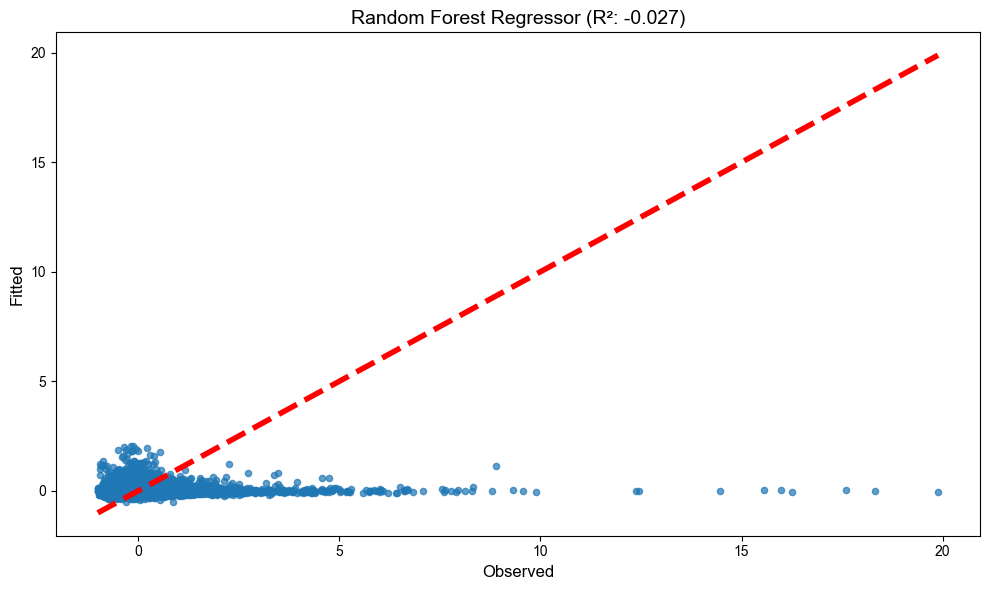

Validation Fold - Random Forest Regressor - R²: -0.126, MAE: 0.112, RMSE: 0.179
Validation Fold - Random Forest Regressor - R²: -0.020, MAE: 0.107, RMSE: 0.192


KeyboardInterrupt: 

In [9]:
run_model_and_plot("Random Forest Regressor", XGBRegressor(), X_data, y_data, add_feature_importance=True, add_shap_analysis=True)